In [1]:
import copy
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import  image_loader as il
import visualize as vs
import torch.optim as optimize
from torch.optim.optimizer import Optimizer
from torchvision import models
from torch.utils.data import DataLoader

/home/nikita/anaconda3/envs/ml-diplom/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [2]:
alex = models.vgg16(pretrained=True)

num_features = alex.classifier[6].in_features
alex.classifier[6] = nn.Linear(num_features, 5) # output labels

loader = il.DatasetLoader.initial()
train = loader.load_tensors(0, 300)
test = loader.load_tensors(400, 450)

train_set = DataLoader(il.ImageDataset(train), batch_size=1, shuffle=True, num_workers=4)
test_set = DataLoader(il.ImageDataset(test), batch_size=1, shuffle=True, num_workers=4)

In [3]:
class GAIN:
    
    def __init__(self, model, layer_name: str, gpu=False,
                 optimizer: Optimizer = None,
                 sigma = 0.2,
                 omega = 100,
                 weight_am = 0.1,
                 weight_e = 10):
        self.model = model

        # set cuda
        self.gpu = gpu
        if self.gpu:
            self.model = self.model.cuda()
            self.tensor_source = torch.cuda
            self.device = 'cuda'
        else:
            self.tensor_source = torch
            self.device = 'cpu'

        self._last_activation = None
        self._last_grad = None

        self.__register_callbacks(layer_name)
        self.loss_cl = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optimize.SGD(self.register_model_params(self.model), lr=0.001, momentum=0.9) \
            if optimizer is None else optimizer
        self.sigma = sigma
        self.omega = omega
        self.weight_am = weight_am
        self.weight_e = weight_e

    def __register_callbacks(self, layer_name: str):

        def forward_callback(module, input_, output_):
            self._last_activation = output_

        def backward_callback(module, grad_in, grad_out):
            self._last_grad = grad_out[0]

        found_layer = False
        for idx, layer in self.model.named_modules():
            if idx == layer_name:
                found_layer = True
                layer.register_forward_hook(forward_callback)
                layer.register_backward_hook(backward_callback)
                break

        if not found_layer:
            raise ValueError("Not found layer:{}".format(layer_name))

    def train(self, data_loader: torch.utils.data.DataLoader, epoch_number:int = 10):
        self.model.train(True)
        best_model_weights = copy.deepcopy(self.model.state_dict())
        best_total = 1e9
        for epoch in range(epoch_number):
            
            loss_cl_sum = 0
            loss_am_sum = 0
            loss_segments_sum = 0
            total_loss_sum = 0
            for inputs, segments, labels in data_loader:
                
                inputs = inputs[0].to(self.device)
                labels = labels[0].to(self.device)
                segments = segments[0].to(self.device)
                
                loss_total, loss_cl, loss_am, loss_e, a_c, i_star = self.russian_forward(self.model, inputs, segments, labels)
                loss_total.backward()
                self.optimizer.step()
                
                total_loss_sum += loss_total.item()
                loss_cl_sum += loss_cl.item()
                loss_am_sum += loss_am.item()
                loss_segments_sum += loss_e.item()
                
            loss_cl_sum = loss_cl_sum / (len(data_loader) * 5) 
            loss_am_sum = loss_am_sum / (len(data_loader) * 5)
            loss_segments_sum = loss_segments_sum / (len(data_loader) * 5)
            total_loss_sum = total_loss_sum / (len(data_loader) * 5)
            
            print("=" * 10)
            print("End epoch: {}/{}".format(epoch + 1, epoch_number + 1))
            print("Total Loss: {}, classification loss: {}, loss AM: {}, loss segments: {}"
                  .format(total_loss_sum, loss_cl_sum, loss_am_sum, loss_segments_sum))
            if total_loss_sum < best_total:
                best_model_weights = copy.deepcopy(self.model.state_dict())
                best_total = total_loss_sum
                
        return self.model, best_model_weights
            
    def russian_forward(self, model, input_image_data, mask_label_data, label_data):
        # N -- labels number
        # input_image_data  BS [5 x 3 x 244 x 244]
        # N == BS
        output_classification = model(input_image_data) # BS x N
        
        # required for get dx / dy for substitution to eq 1
        grad_target = (output_classification.float() * label_data).sum()
        grad_target.backward(gradient=output_classification * label_data, retain_graph=True)

        model.zero_grad()
        self.optimizer.zero_grad()
        
        # Eq 1
        # find w_c from evaluate grad model for specified layer
        layer_gradient = self._last_grad # BS x C x H x W
        
        bs, c, h, w = layer_gradient.size()
        w_c = F.avg_pool2d(layer_gradient, (h, w), 1)  # BS x C x 1 x 1
   
        # Eq 2
        # reshape current weights for compability with w_c
        f_weights = self._last_activation 
        f_weights_new_shape = (1, f_weights.shape[0] * f_weights.shape[1], f_weights.shape[2], f_weights.shape[3]) # 1 x (BS x C) x H x W
        f_weights = f_weights.view(f_weights_new_shape)
        
        
        a_c = F.relu(F.conv2d(f_weights, w_c, groups=bs))
        a_c = F.interpolate(a_c, size=input_image_data.size()[2:], mode='bilinear', align_corners=False)
        a_c = a_c.permute((1, 0, 2, 3))
        # calculate old plain classification loss
        loss_cl = self.loss_cl(output_classification, label_data)
        
        # her we has output_classification, classification_loss, a_c
        _, i_star = self.__mask_image(input_image_data, a_c)
        
        # here we want decrease weights, which are'nt marked by previous model as segment-importanse 
        output_am = model(i_star)
        
        loss_am = (F.sigmoid(output_am) * label_data).sum() / (label_data.sum().type(self.tensor_source.FloatTensor) + 1.0)
        loss_am = torch.tensor([1.0]) if loss_am.item() > 1e9 else loss_am  
        loss_e = ((mask_label_data - a_c) ** 2).sum()
        loss_total = loss_cl + self.weight_am * loss_am + self.weight_e * loss_e

        return loss_total, loss_cl, loss_am, loss_e, a_c, i_star 

    def __mask_image(self, data_image, a_c):
        # Eq 4
        # I don't understand bellow 3 lines
        a_c_min = a_c.min()
        a_c_max = a_c.max()
        
        a_c = a_c if (a_c_max - a_c_min).item() == 0 else (a_c - a_c_min) / (a_c_max - a_c_min)
    
        t_a_c = F.sigmoid(self.omega * (a_c - self.sigma))
        # Eq 3
        masked_image = data_image - (data_image * t_a_c)
        return a_c, masked_image
    
    @staticmethod
    def register_model_params(model):
        params = []
        for _, param in model.named_parameters():
            params.append(param)
        return params

gg = GAIN(alex, "features.28", gpu=True)

In [4]:
current_model, best_model_w = gg.train(train_set, 50)
best_model_m = alex.load_state_dict(best_model_w)

/home/nikita/anaconda3/envs/ml-diplom/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


End epoch: 1/51
Total Loss: nan, classification loss: nan, loss AM: nan, loss segments: 11300275.921971349
End epoch: 2/51
Total Loss: nan, classification loss: nan, loss AM: nan, loss segments: 1173.4038932240803
End epoch: 3/51
Total Loss: nan, classification loss: nan, loss AM: nan, loss segments: 1173.4038932240803
End epoch: 4/51
Total Loss: nan, classification loss: nan, loss AM: nan, loss segments: 1173.4038932240803
End epoch: 5/51
Total Loss: nan, classification loss: nan, loss AM: nan, loss segments: 1173.4038932240803
End epoch: 6/51
Total Loss: nan, classification loss: nan, loss AM: nan, loss segments: 1173.4038932240803
End epoch: 7/51
Total Loss: nan, classification loss: nan, loss AM: nan, loss segments: 1173.4038932240803
End epoch: 8/51
Total Loss: nan, classification loss: nan, loss AM: nan, loss segments: 1173.4038932240803
End epoch: 9/51
Total Loss: nan, classification loss: nan, loss AM: nan, loss segments: 1173.4038932240803
End epoch: 10/51
Total Loss: nan, cla

/home/nikita/PycharmProjects/ml-diplom/visualize.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


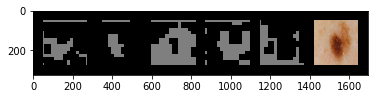

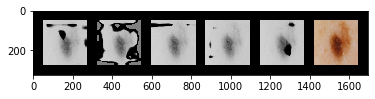

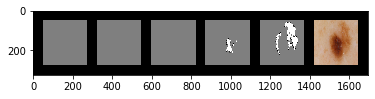

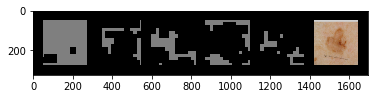

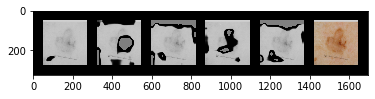

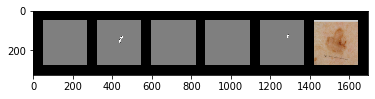

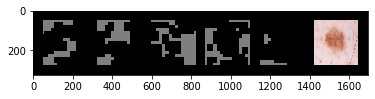

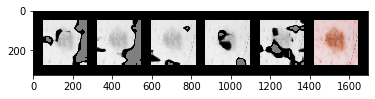

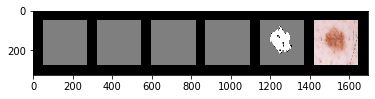

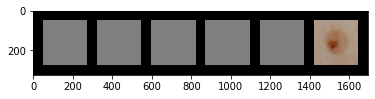

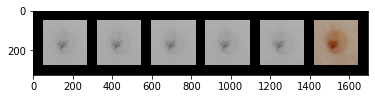

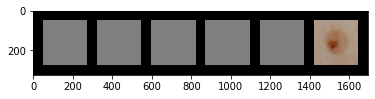

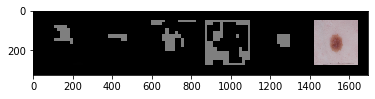

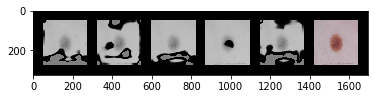

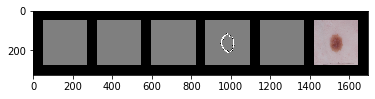

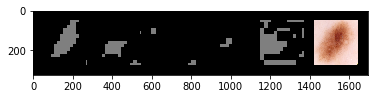

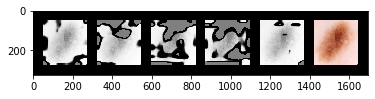

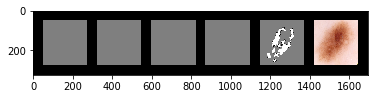

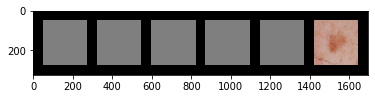

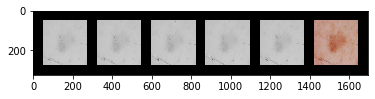

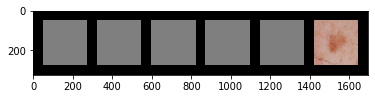

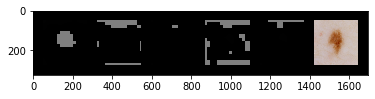

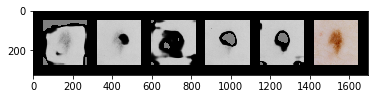

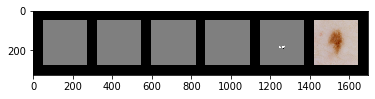

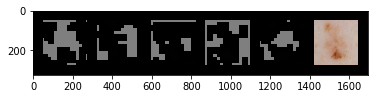

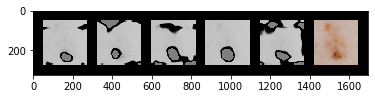

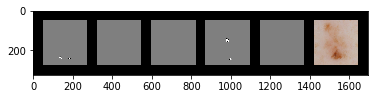

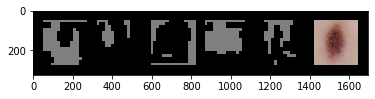

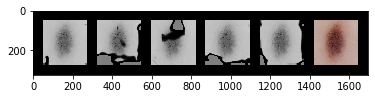

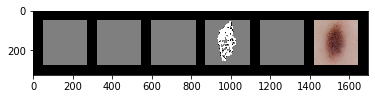

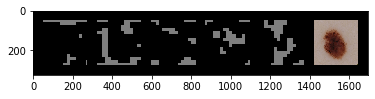

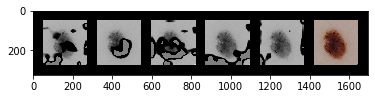

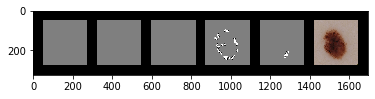

<Figure size 432x288 with 0 Axes>

In [6]:

for idx, (inputs, segments, labels) in enumerate(test_set):
    if idx > 10:
        continue
    inputs = inputs[0].to('cuda')
    labels = labels[0].to('cuda')
    segments = segments[0].to('cuda')
    _, _, _, _, a_c, i_start = gg.russian_forward(current_model, inputs, segments, labels)
    a_c = a_c.cpu()
    i_start = i_start.cpu()
    inputs = inputs.cpu()
    vs.visualize_tensor(a_c, inputs)
    vs.visualize_tensor(i_start, inputs)
    vs.visualize_tensor(segments, inputs)